In [1]:
from iqwaveform import fourier
import numpy as np

### Sampling parameters that satisfy the constant-overlap-and-add (COLA) constraint

In [2]:
from scipy import signal

# There are only a few window and noverlap combinations for perfect STFT reconstruction.
# Those are the ones that meet the "constant overlap and add" constraint:
# Ref: https://www.dsprelated.com/freebooks/sasp/Overlap_Add_OLA_STFT_Processing.html

N = 512  # desired number of points of the STFT in the frequency domain

# For a 2-term (L=3) Hamming window: nperseg=M=512*2/1, R=M*1/2, noverlap=M*(1-1/2)=512
assert signal.check_COLA('hamming', nperseg=2 * N, noverlap=N)

# For a 3-term (L=4) Blackman window: nperseg=M=512*3/2, R=M*1/3, noverlap=M*(1-1/3)=512
assert signal.check_COLA('blackman', nperseg=(N * 3) // 2, noverlap=N)

# For a 4-term (L=5) Blackman-Harris window, R=M/L=M/4, so if noverlap=512=M*(1-1/4) then nperseg=noverlap*(5/4).
# Others are possible (see below) but STFT evaluation for high overlap is expensive
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=940309
assert signal.check_COLA('blackmanharris', nperseg=(N * 5) // 4, noverlap=N)

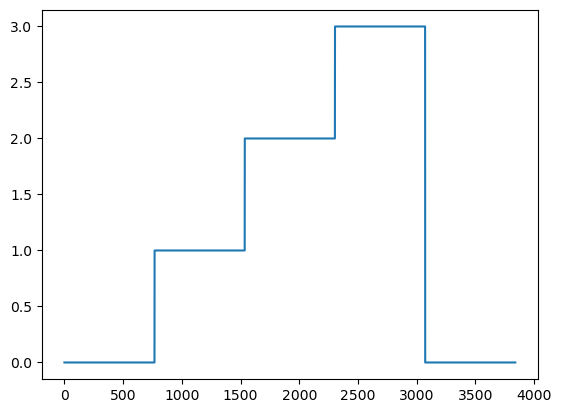

In [28]:
from matplotlib import pyplot as plt

fft_size = 768
x = np.r_[np.arange(4),0].repeat(fft_size).astype('complex64')

plt.plot(x.real)

(768, 17)


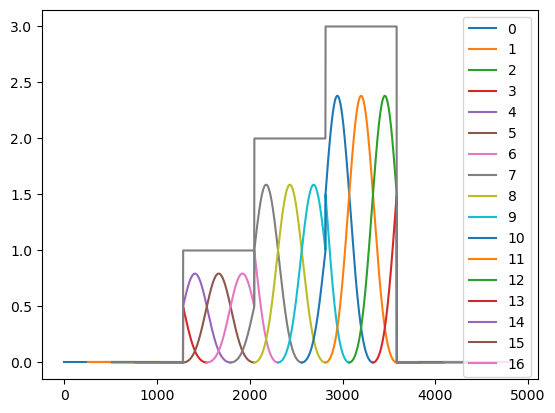

In [29]:
noverlap = 2 * fft_size // 3
window = fourier._get_window('blackman', fft_size, norm=False)

y = fourier._to_overlapping_windows(
    x, window=window, nperseg=fft_size, noverlap=noverlap
).T
print(y.shape)
# y = y.reshape((y.shape[0]*y.shape[1],) + y.shape[2:])

hop_size = fft_size - noverlap
reconstr = np.zeros(x.shape[0] + 2 * noverlap)
for i in range(y.shape[1]):
    reconstr[i * hop_size : i * hop_size + fft_size] += y.real[:, i]
    plt.plot(np.arange(y.shape[0]) + i * hop_size, y.real[:, i], label=i)

reconstr[:noverlap] = np.nan
reconstr[-noverlap:] = np.nan

plt.plot(np.arange(reconstr.size), reconstr)
plt.legend()

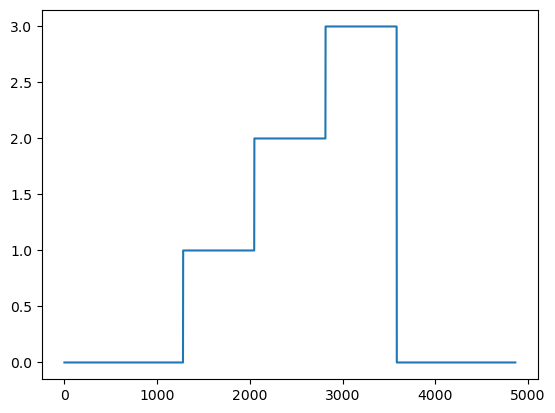

In [30]:
y = fourier._to_overlapping_windows(
    x, window=window, nperseg=fft_size, noverlap=noverlap
)
xr = fourier._from_overlapping_windows(y, noverlap, axis=0)
plt.plot(xr.real)

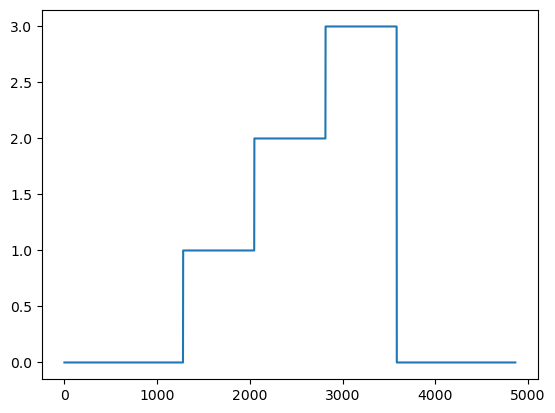

In [31]:
y = fourier._to_overlapping_windows(
    np.array(x), window=np.array(window), nperseg=fft_size, noverlap=noverlap
)
xr = fourier._from_overlapping_windows(y, noverlap, axis=0)
plt.plot(xr.real)

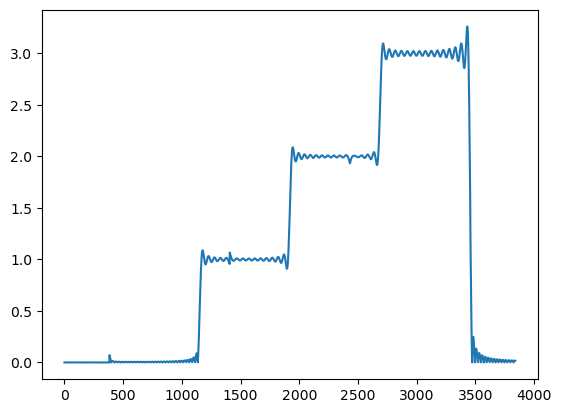

In [32]:
# from cupyx import scipy
import scipy
from iqwaveform import fourier

xr = fourier.ola_filter(
    np.array(x),
    fs=10e6,
    passband=(-.2e6, .2e6),
    window='hamming',
    noverlap=1024,
    axis=0,
)

plt.plot(np.abs(xr))